In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch

C:\Users\vivek\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\vivek\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
#!pip install ultralytics


In [1]:
## Extracting digits from file name

In [13]:
dataset_path = './dataset'


In [14]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)
    
    if match:
        return int(match.group(0))
    else:
        return 0


In [15]:
print(the_number_in_the_string("file123.txt"))  
print(the_number_in_the_string("no_numbers"))


123
0


In [16]:
# Formatting the XML File and creating DF

In [17]:
#to store labels and image info
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)


In [19]:
import os
from glob import glob

#get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')

print(len(xml_files))


433


In [20]:
import xml.etree.ElementTree as xet


In [21]:
import cv2

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    
    info = xet.parse(filename)
    root = info.getroot()    
    
 # Finding BB info
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
# join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    
# add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
# Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
    alldata = pd.DataFrame(labels_dict)


In [22]:
alldata.head()

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,./dataset\images\Cars0.png,226,419,125,173,500,268
1,./dataset\images\Cars1.png,134,262,128,160,400,248
2,./dataset\images\Cars2.png,229,270,176,193,400,400
3,./dataset\images\Cars3.png,142,261,128,157,400,225
4,./dataset\images\Cars4.png,156,503,82,253,590,350


In [24]:
from sklearn.model_selection import train_test_split

# train test val split
train, test = train_test_split(alldata, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 350
      len(val) = 39
      len(test) = 44



In [25]:
train.head()

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
103,./dataset\images\Cars103.png,230,248,129,134,400,196
246,./dataset\images\Cars246.png,49,112,163,193,400,267
182,./dataset\images\Cars182.png,168,247,139,159,400,225
321,./dataset\images\Cars321.png,134,169,235,246,301,400
237,./dataset\images\Cars237.png,118,154,148,169,236,314


In [26]:
val.head()

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
215,./dataset\images\Cars215.png,92,162,105,123,400,225
84,./dataset\images\Cars84.png,167,238,201,220,400,300
23,./dataset\images\Cars23.png,143,213,172,211,400,299
66,./dataset\images\Cars66.png,144,211,170,202,400,299
50,./dataset\images\Cars50.png,116,525,55,262,590,350


In [27]:
test.head()

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
425,./dataset\images\Cars425.png,211,301,103,132,500,232
75,./dataset\images\Cars75.png,209,218,196,201,400,248
181,./dataset\images\Cars181.png,69,128,195,209,225,400
30,./dataset\images\Cars30.png,155,200,169,182,400,240
364,./dataset\images\Cars364.png,61,115,140,167,400,242


In [28]:
# Creating data in YOLO format¶


In [31]:
import shutil

# remove if exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')


In [32]:
def make_split_folder_in_yolo_format(split_name, split_df):
# folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

    # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")


In [33]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)


Created 'datasets\cars_license_plate_new\train\images' and 'datasets\cars_license_plate_new\train\labels'
Created 'datasets\cars_license_plate_new\val\images' and 'datasets\cars_license_plate_new\val\labels'
Created 'datasets\cars_license_plate_new\test\images' and 'datasets\cars_license_plate_new\test\labels'


In [34]:
# Object detection and bounding box¶


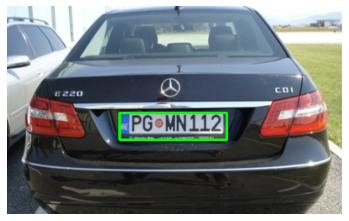

In [38]:
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'


image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]


image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:
    
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

# Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')  
plt.show()  


In [40]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file


with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)


In [41]:
# Using YOLOv8 nano model¶


In [42]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')


100%|█████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 12.9MB/s]


In [44]:
model.train(
    data='datasets.yaml',  
    epochs=10,            
    batch=16,              
    device='cpu',         
    imgsz=320,  # Image size (width and height) for training           
    cache=True             
)


New https://pypi.org/project/ultralytics/8.2.90 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.89  Python-3.9.7 torch-2.1.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning G:\ComputerVision_Projects\Number_Plate_Recognition\datasets\cars_license_plate_new\train\labels.cache.
train: Caching images (0.1GB RAM): 100%|██████████| 350/350 [00:01<00:00, 216.01it/s]
val: Scanning G:\ComputerVision_Projects\Number_Plate_Recognition\datasets\cars_license_plate_new\val\labels.cache... 3
val: Caching images (0.0GB RAM): 100%|██████████| 39/39 [00:00<00:00, 205.43it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
"No such keys(s): 'mode.use_inf_as_null'"
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.555      1.908      1.223         14        320: 100%|██████████| 22/22 [00:58<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         39         39    0.00393      0.949      0.169     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.505      1.553       1.16         14        320: 100%|██████████| 22/22 [00:55<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         39         39     0.0947      0.641      0.568      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.554      1.477      1.154         14        320: 100%|██████████| 22/22 [00:56<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0

                   all         39         39      0.581       0.41      0.447      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.494      1.396      1.202         14        320: 100%|██████████| 22/22 [00:43<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.143      0.205     0.0897     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.53      1.421      1.284         14        320: 100%|██████████| 22/22 [00:35<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.794      0.396      0.522      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.444      1.329      1.193         14        320: 100%|██████████| 22/22 [00:33<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.564       0.53      0.513      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.435       1.22       1.22         14        320: 100%|██████████| 22/22 [00:38<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.693      0.754      0.768      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.437       1.12      1.197         14        320: 100%|██████████| 22/22 [00:34<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.888      0.769      0.878      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.364      1.076       1.15         14        320: 100%|██████████| 22/22 [00:33<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39       0.92      0.897      0.903      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.324       1.02      1.157         14        320: 100%|██████████| 22/22 [00:31<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all         39         39      0.867      0.897      0.911      0.514



10 epochs completed in 0.128 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.89  Python-3.9.7 torch-2.1.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0


                   all         39         39      0.919      0.871      0.903      0.533
Speed: 0.6ms preprocess, 34.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001CAA0201070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

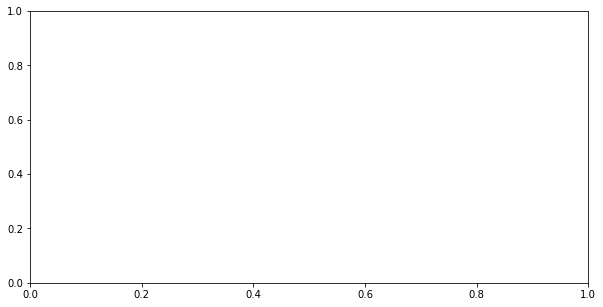

In [45]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1 
mAP_0_5 = results['metrics/mAP50(B)'] 
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)


In [46]:
## Save model

In [48]:
model.save('license_plate_model.pt')


In [52]:
# to predict test image
def predict_and_plot(path_test_car):
   
    results = model.predict(path_test_car, device='cpu')

    
    image = cv2.imread(path_test_car)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    for result in results:
        for box in result.boxes:
            
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    
    plt.imshow(image)
    plt.axis('off')  
    plt.show()  


image 1/1 G:\ComputerVision_Projects\Number_Plate_Recognition\dataset\images\Cars353.png: 224x320 1 license_plate, 53.1ms
Speed: 0.9ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 320)


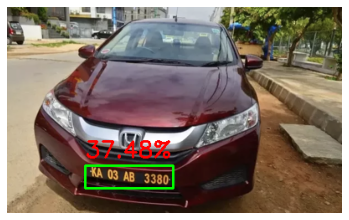

In [56]:
predict_and_plot(test.iloc[22].img_path)


In [73]:
## Employing OCR for text recognition

In [74]:
import pytesseract
from pytesseract import Output


In [75]:
# Specify the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [76]:
## Load model

In [77]:
# using YOLOv8 nano
from ultralytics import YOLO

model = YOLO('./license_plate_model.pt')

print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [78]:
def predict_and_plot(path_test_car):
    
    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    for result in results:
        for box in result.boxes:
            
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # crop img
            roi = image[y1:y2, x1:x2]

        # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    
    plt.imshow(image)
    plt.axis('off') 
    plt.show() 


In [79]:
test.iloc[0].img_path

'./dataset\\images\\Cars425.png'


image 1/1 G:\ComputerVision_Projects\Number_Plate_Recognition\dataset\images\Cars425.png: 320x640 1 license_plate, 113.8ms
Speed: 0.0ms preprocess, 113.8ms inference, 5.7ms postprocess per image at shape (1, 3, 320, 640)
Detected text: G526 JHD



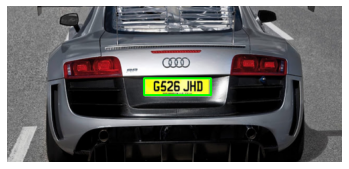

In [80]:
predict_and_plot(test.iloc[0].img_path)


In [89]:
results = model.predict(test.iloc[0].img_path, device='cpu')
for result in results:
    print(result.boxes)


image 1/1 G:\ComputerVision_Projects\Number_Plate_Recognition\dataset\images\Cars425.png: 320x640 1 license_plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.7474])
data: tensor([[204.6072, 107.3141, 304.6069, 132.5158,   0.7474,   0.0000]])
id: None
is_track: False
orig_shape: (232, 500)
shape: torch.Size([1, 6])
xywh: tensor([[254.6070, 119.9149,  99.9997,  25.2018]])
xywhn: tensor([[0.5092, 0.5169, 0.2000, 0.1086]])
xyxy: tensor([[204.6072, 107.3141, 304.6069, 132.5158]])
xyxyn: tensor([[0.4092, 0.4626, 0.6092, 0.5712]])


In [90]:
from PIL import Image

image = Image.open(test.iloc[0].img_path)
image_rgb = image.convert('RGB')

image_array = np.array(image_rgb)

# Predict using the image array
results = model.predict(image_array)

# Print or process the results
for result in results:
    print(result.boxes)



0: 320x640 1 license_plate, 69.0ms
Speed: 1.9ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8571])
data: tensor([[204.6425, 106.3328, 304.2991, 132.5402,   0.8571,   0.0000]])
id: None
is_track: False
orig_shape: (232, 500)
shape: torch.Size([1, 6])
xywh: tensor([[254.4708, 119.4365,  99.6566,  26.2074]])
xywhn: tensor([[0.5089, 0.5148, 0.1993, 0.1130]])
xyxy: tensor([[204.6425, 106.3328, 304.2991, 132.5402]])
xyxyn: tensor([[0.4093, 0.4583, 0.6086, 0.5713]])
